In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
import os
import numpy as np
import scipy.stats as stats

ROOT_PATH = Path('/mnt/2021_NIA_data/projects/nbb')
VIDEO_PATH = ROOT_PATH.joinpath("video")
HEADPOSE_PATH = VIDEO_PATH.joinpath("headpose_data")

# Determine the project path based on the current working directory or the script's path
try:
    PROJECT_PATH = Path(__file__).parents[1]
except NameError:
    PROJECT_PATH = Path(os.getcwd()).parents[0]

FIGURE_PATH = Path(PROJECT_PATH, "figures")


def skewness(series):
    return stats.skew(series)

def kurtosis(series):
    return stats.kurtosis(series)

data = pd.read_csv(Path(HEADPOSE_PATH, "headpose_values.csv"))
data['participant_id'] = data['participant_id'].str.replace('td', '').astype(int)

In [2]:
# Compute summary statistics for each head-pose feature per participant
summary_values = data.groupby('participant_id')[['yaw', 'pitch', 'roll']].agg([np.mean, np.std, skewness, kurtosis]).reset_index()

# Flatten multiindex columns
summary_values.columns = [col[0] if col[1] == '' else '_'.join(col) for col in summary_values.columns.values]

# Scale the summary statistics
scaler = StandardScaler()
summary_values_scaled = scaler.fit_transform(summary_values.drop(columns=['participant_id']))

In [3]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(summary_values_scaled)

/home/cko4/2023_asd_gaze/.venv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2, random_state=0)

In [4]:
summary_values['cluster'] = kmeans.labels_

In [5]:
summary_values.head()

,participant_id,yaw_mean,yaw_std,yaw_skewness,yaw_kurtosis,pitch_mean,pitch_std,pitch_skewness,pitch_kurtosis,roll_mean,roll_std,roll_skewness,roll_kurtosis,cluster
0,1,-71.933155,20.523933,-0.831891,1.549955,-31.162028,15.437783,0.107283,-0.610581,-128.732684,39.196718,3.325016,19.052372,1
1,2,-37.908546,43.937787,0.542445,1.883642,5.566585,36.575493,0.184310,-0.174052,76.509382,124.241667,-0.874984,-0.717349,0
2,5,-19.339498,61.881905,0.145139,-1.842559,-13.715544,11.668271,1.265573,1.542430,50.185168,54.581020,-0.031260,-1.487347,0
3,6,-21.829601,66.584096,0.407703,-1.624944,-17.836736,9.478149,1.069306,2.139619,51.943744,57.738960,-0.246673,-1.541869,0
4,8,-26.299362,54.347670,0.476994,-1.648026,5.053660,14.193383,-0.636147,-0.115345,-1.990918,91.458392,0.071911,-0.742377,0


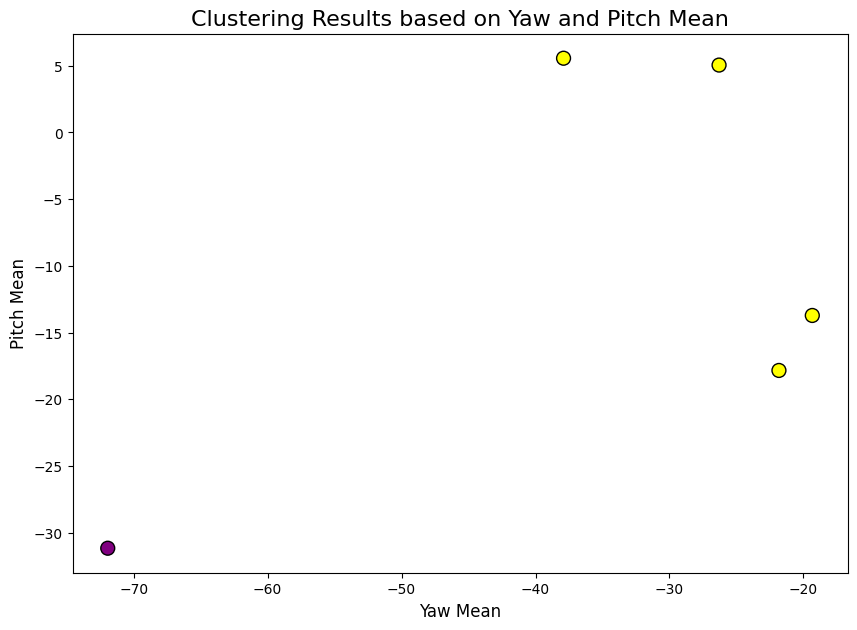

In [10]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

plt.figure(figsize=(10, 7))

# Create a custom colormap
cmap = mcolors.LinearSegmentedColormap.from_list("", ["yellow", "purple"])

# Create an array for colors
clusters = summary_values['cluster']
colors = np.where(clusters==0, 'yellow', 'purple')

plt.scatter(summary_values['yaw_mean'], summary_values['pitch_mean'], c=colors, s=100, edgecolors='k')
plt.xlabel('Yaw Mean', fontsize=12)
plt.ylabel('Pitch Mean', fontsize=12)
plt.title('Clustering Results based on Yaw and Pitch Mean', fontsize=16)
plt.show()


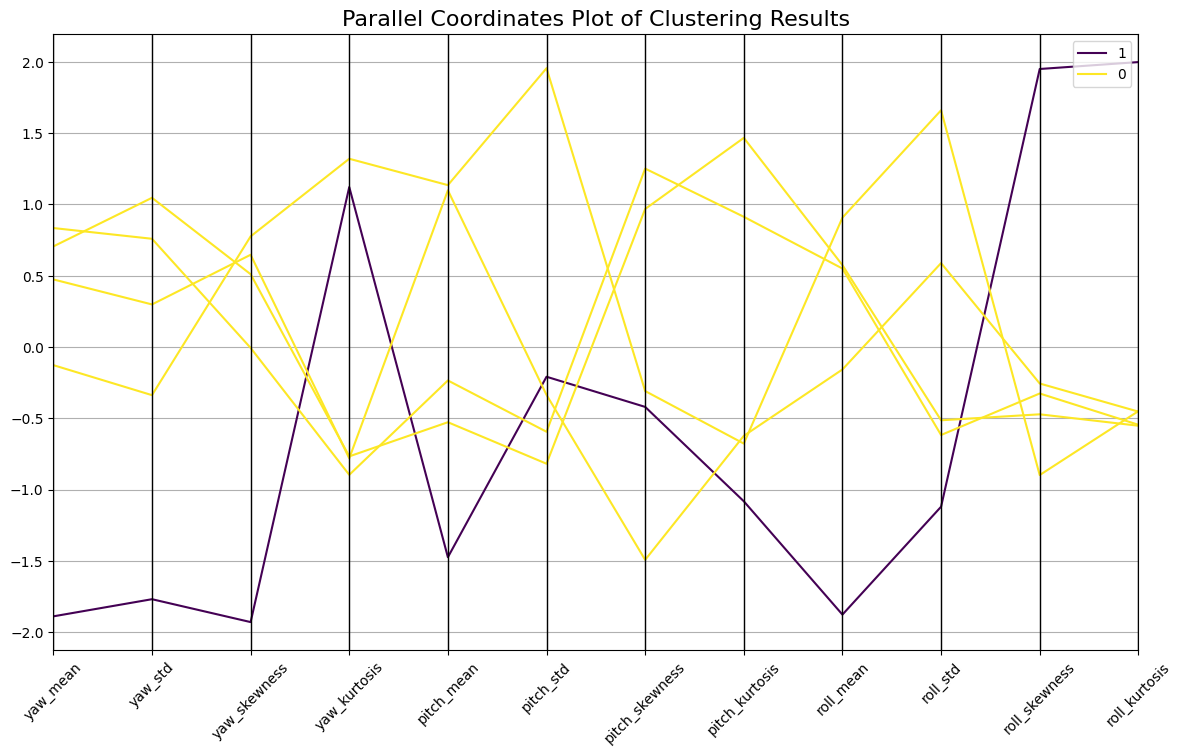

In [7]:
from pandas.plotting import parallel_coordinates

# Add cluster labels to the summary_values_scaled DataFrame
summary_values_scaled_df = pd.DataFrame(summary_values_scaled, columns=summary_values.columns.drop(['participant_id', 'cluster']))
summary_values_scaled_df['cluster'] = summary_values['cluster']

plt.figure(figsize=(14, 8))
parallel_coordinates(summary_values_scaled_df, 'cluster', colormap='viridis')
plt.title('Parallel Coordinates Plot of Clustering Results', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [11]:
for cluster, participants in summary_values.groupby('cluster')['participant_id']:
    print(f"Cluster {cluster}: {participants.values}")

Cluster 0: [2 5 6 8]
Cluster 1: [1]
